In [ ]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import json
import csv
import logging
from tqdm import tqdm
import torch
import datasets
from datasets.combine import *
import PIL
from collections import OrderedDict
import time
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from timm import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
from torchvision.transforms.v2 import functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
from kornia import filters
import kornia.augmentation as K


# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually


_URLS = {'root': os.curdir,'cache_dir':"raw"}
_BATCH_SIZE = 2
_NUM_WORKERS = 8
_TRAIN_SPLIT = {'d1':1,'d2':2,'d3':3, 'd4':4}
_VALID_SPLIT = '0'
_TEST_SPLIT = "chabud"
_INPUT_SIZE = 512
_PATCHES_SIDE = 3


/home/w1nlin4n/miniconda3/envs/pytorch-learning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Тут можна задати спліти 0-4, що дає вчитися і перевіряти метрики на незалежних вибірках



In [ ]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])
sys.path.append(os.path.abspath('..'))

# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

HF_DATASETS_CACHE set to: ./raw


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device)

In [ ]:
# Load the CaBuAr dataset
# Possible splits: 0-4, or chabud
# For docs check out
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar
d1 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d1']}", trust_remote_code=True)
d2 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d2']}", trust_remote_code=True)
d3 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d3']}", trust_remote_code=True)
d4 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d4']}", trust_remote_code=True)
valid_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_VALID_SPLIT}',trust_remote_code=True).with_format("torch")
test_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_TEST_SPLIT}',trust_remote_code=True).with_format("torch")

train_data = interleave_datasets([d1, d2, d3, d4], stopping_strategy='all_exhausted').with_format("torch")


### На основі аналізу датасету запроповані рішення для перетворення датасету
 - Create an class ratio graphic in output mask

Бінарність класів спрощує Segmentation loss в просту бінарну кроссентропію з логітами.
 Використаємо взваження класів відносно їх частоти в зображенні всередині  лосс функції за допомогою class_weights.
Додаємо до BCE лосс-функції додатково Dice loss, що є диферренційованим F1 score

 - Mean brightness, distribution per-channel of images

Додамо першим шаром батч нормалізацію,

**Створимо синтез фіч**:
1.  порахувавши індекс щільності рослинності (NDVI): гіперболічну дистанцію між яскравістю пікселів Червоного (B04), Інфрачервоного (B08) каналів першим каналом,
2. А також для Довгих інфрачервоних DWDM каналів B12 і B11.

3. Останнім каналом візьмемо B09, для відокремлення вологого грунту
від спаленої землі і водних об'єктів.

Присутність великого набору семплів з пустими масками (class 0) підвищує захищеність моделі

Для зменшення шуму окремо згладимо вхідне зображення з Гауссовим блюром

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed?

Так як не присутня залежність між зображеннями в батчі, регуляризація виконується для кожної пари вхідне зображення --- маска:

1. До вхідного зображення додається невелика кількість шуму

2. З RandomJigsaw синхронно розрізаємо зображення та маску на квадрати NxN і перемішуємо їх

3. Під час тренування для одночасно маски і зображення робимо афінне перетворення, відображаємо вертикально та горизонтально

Ціллю є підвищення інваріантності по переміщенню і обертанню, подальше використання dropout для зменшення глобальних глобальних активацій нейронів, і більшого фокусу моделі на локальних фічах, інваріантно від топографії ландшафту і присутніх на ньому географічних ознак.

# Preprocessing

- Hyperbolic difference

Відображає нелінійний ріст залежності, накладає вагу для збільшення контрасту між схожими значеннями і аутлаєрами, додає біас.

In [ ]:
def hyperbolic_diff(img_x, img_y, scale = 0.5, bias = 0):
    if bias == -1e-6:
        bias = 0
    return scale * (img_x - img_y) / (img_x + img_y + bias + 1e-6)

Перетворення листків датасету в тензори toTensor замінено на torch.tensor()

- Transform виконується одночасно на вхідному зображенні і масці; стосується лише афінних перетворень без зміни кольорів

- Augmentation - лише для вхідного зображення post_fire - згладжує зображення для ідентифікації грубих фіч, видаляє частину інформації для підвищення робастності на реальному тестуванні

- Important to denoise the data,
 using gaussian blur pyramids

In [ ]:
gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
adjust_contrast = transforms.ColorJitter(contrast=1.5)

transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomRotation(degrees=(80, 100))
    ]),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

augmentation = transforms.Compose([
    transforms.GaussianNoise(sigma=0.12),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
])

- Define scripts to convert image to 3 channel image
- Define clipping of class values
-  Normalization
- Showing before/after
- Resizing of images, important for  (Optional)

## Three channels
- (Natural Density of Vegetation, Water vapor intensity, medium-long infrared ratio)

- Розділяємо батч на окремі зображення (3, 512, 512) і маску (1, 512, 512)

Видалені канали:

- B01 - рівень аерозолю

- B02, 03 - зелений і синій, видима неозброєним оком рослинність і водойми

- B05-07 - Класифікація рослинних культур

- B10 - Тип хмар

- Всі інші канали крім B04, B08, B09, B11, B12 дропаємо для зменшення зайвого об'єму інформації поданого на вхід, і використання претренованих ваг.


In [ ]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, augment=None):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.augment = augment


    def calculate_ndvi(self, pre_fire, post_fire):
        # Assuming NIR is channel 8 and Red is channel 4 (0-indexed)
        pre_nir = pre_fire[7, :, :]
        pre_red = pre_fire[3, :, :]
        post_nir = post_fire[7, :, :]
        post_red = post_fire[3, :, :]

        # Compute hyperbolic difference of channels
        ndvi_pre = hyperbolic_diff(pre_nir, pre_red, scale=5.67, bias=0.5)
        ndvi_post = hyperbolic_diff(post_nir, post_red, scale=5.67, bias=0.5)

        # Return a mean square distance between old and new
        return torch.square(ndvi_post - ndvi_pre)
        #return ndvi_post


    def fire_boundary(self, pre_fire, post_fire):
        # Extract low frequency bands:
        pre_band_11 = pre_fire[10, :, :]
        pre_band_12 = pre_fire[11, :, :]
        boundary_pre = hyperbolic_diff(pre_band_11, pre_band_12, 8.5, 0.5)

        post_band_11 = post_fire[10, :, :]
        post_band_12 = post_fire[11, :, :]
        boundary_post = hyperbolic_diff(post_band_11, post_band_12, 8.5, 0.5)  # Shape: [1, H, W]

        return torch.square(boundary_post - boundary_pre)

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']
        pre_fire = sample['pre_fire']
        mask = sample['mask']

        # Reshaping and retyping tensors
        post_fire = post_fire.to(torch.float).permute(2, 0, 1)
        pre_fire = pre_fire.to(torch.float).permute(2, 0, 1)
        mask = mask.to(torch.float).permute(2, 0, 1)

        # Calculate NDVI - natural vegetation index
        ndvi = self.calculate_ndvi(pre_fire, post_fire)

        # Compute fire boundary using sentinel script
        fire_boundary = self.fire_boundary(pre_fire, post_fire)

        # Extract water vapor band 09
        water_vapor = hyperbolic_diff(post_fire[8,:,:],pre_fire[8, :, :], bias=5.67)

        # Augment layers: edge detection, saturation etc.
        if self.augment:
            ndvi = self.augment(ndvi.unsqueeze(0))
            water_vapor = self.augment(water_vapor.unsqueeze(0))
            fire_boundary = self.augment(fire_boundary.unsqueeze(0))

        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.stack([ndvi.squeeze(), water_vapor.squeeze(), fire_boundary.squeeze(), mask.squeeze()], dim=0)  # 4 channels]

        # Transform all layers uniformly, to maintain ground truth on validation
        if self.transform:
            combined_input = self.transform(combined_input)

        # Prepare the X_input and y
        return combined_input[:-1], torch.round(combined_input[-1].unsqueeze(0))

Обгортка для передачі даних на CUDA

In [ ]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

Train, validation і test лоадери

In [ ]:

# Instantiate the custom dataset
train_dataset = CaBuArPyTorchDataset(
    hf_dataset=train_data,
    transform=transform,
    augment=augmentation,
)
valid_dataset = CaBuArPyTorchDataset(
    hf_dataset=valid_data,
)
test_dataset = CaBuArPyTorchDataset(
    hf_dataset=test_data,
)

tr_loader = WrappedDataLoader(DataLoader(
    train_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=True,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
vd_loader = WrappedDataLoader(DataLoader(
    valid_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
test_loader = WrappedDataLoader(DataLoader(
    test_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)

In [ ]:
print(f"train: {len(train_dataset)}")
print(f"valid: {len(valid_dataset)}")
print(f"test: {len(test_dataset)}")

train: 340
valid: 78
test: 68


Перевірка на доступність до завантаження файлів датасету

In [ ]:
%%time
# Example: Iterate through the DataLoader
for batch_idx, batch in enumerate(tr_loader):
    X, y = batch

    # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
    # Example:
    # outputs = model(post_fire, pre_fire)
    # loss = criterion(outputs, mask)

    # For demonstration, we'll just print the batch shapes
    print(f"Batch {batch_idx}:")
    print(f"  post_fire shape: {X.shape}")
    print(f"  mask shape: {y.shape}")

    # Break after first batch for demonstration
    if batch_idx == 0:
        break

Batch 0:
  post_fire shape: torch.Size([2, 3, 512, 512])
  mask shape: torch.Size([2, 1, 512, 512])
CPU times: user 312 ms, sys: 326 ms, total: 638 ms
Wall time: 2.33 s


### Відображення результатів препроцессингу

- Виділимо 5 випадкових зображень з train і test спліту

- Train додає трансформації до зображення

- Test показує оригінал без перетворень

### Зауваження

- В датасеті присутні як денні зображення, так і нічні. NDVI індекс виділяється добре лише на денних зображеннях.

In [ ]:
idx, processed_img = next(enumerate(tr_loader))

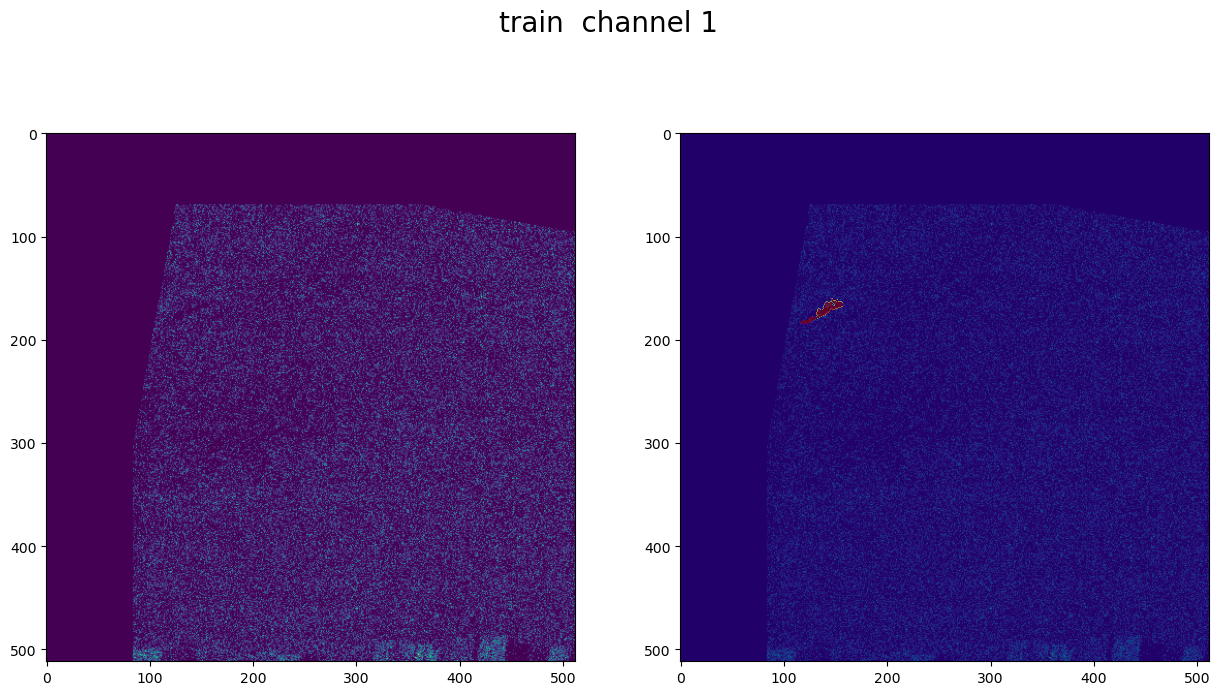

In [ ]:

# Let's plot some images
def draw_transforms(batch_img, batch_size, ch, caption:str):
  x, y = batch_img
  fig, axes = plt.subplots(batch_size // 2, 2, figsize=(15,8))
  fig.suptitle(f"{caption}  channel {ch}", fontsize=20)
  im_pos = 0
  for i in range(batch_size):
      axes[im_pos % 2].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy())
      im_pos += 1
      axes[im_pos % 2].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy())
      axes[im_pos % 2].imshow(y[i].view(_INPUT_SIZE,_INPUT_SIZE,1).cpu().numpy(), cmap='jet', alpha=0.5)
      im_pos += 1
  plt.show()

draw_transforms(processed_img, _BATCH_SIZE, 1, "train")

In [ ]:
idx, test_img = next(enumerate(test_loader))

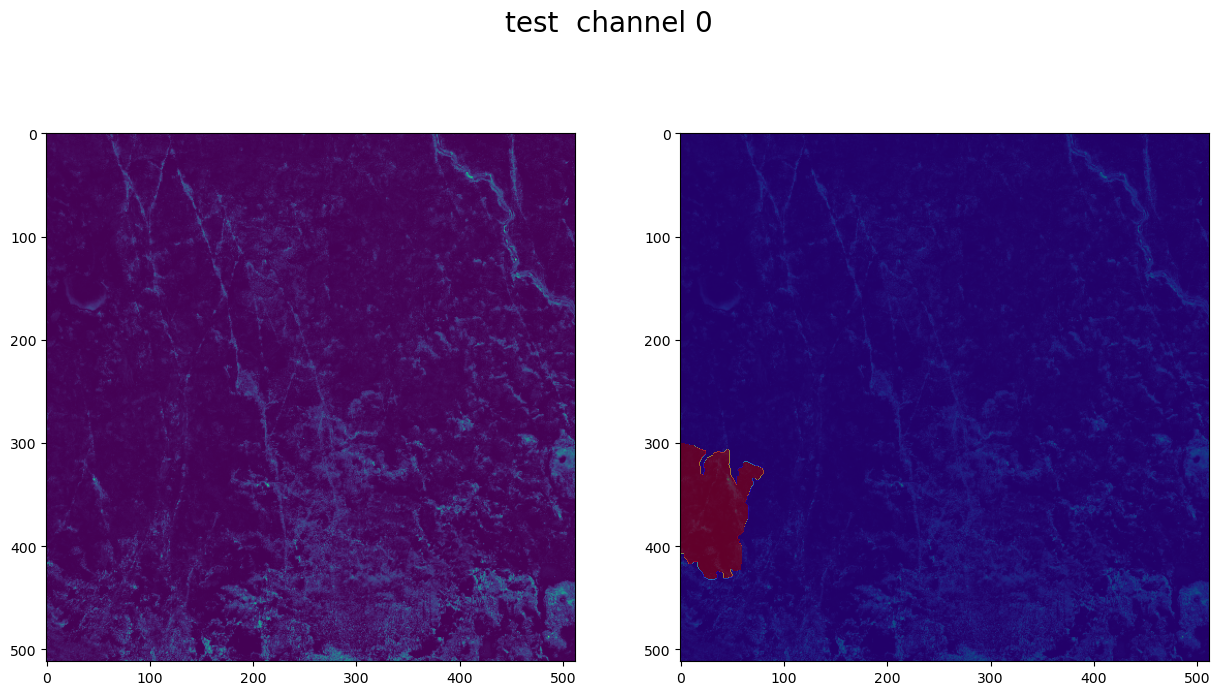

In [ ]:
draw_transforms(test_img, _BATCH_SIZE, 0, "test")

## Використовуємо за Loss Combined BCE + F1 (Dice loss)

## Метрики - попіксельно F1/AuC та Extended IoU

Покращений IoU враховує відстань між масками і ground truth навіть за нульового перекриття, уникає плато нульового градієнту.

In [ ]:
def write_results(results_file, results, format='csv'):
    with open(results_file, mode='w') as cf:
        if format == 'json':
            json.dump(results, cf, indent=4)
        else:
            if not isinstance(results, (list, tuple)):
                results = [results]
            if not results:
                return
            dw = csv.DictWriter(cf, fieldnames=results[0].keys())
            dw.writeheader()
            for r in results:
                dw.writerow(r)
            cf.flush()

def get_outfile(path, *paths, inc=False):
    outfile = os.path.join(path, *paths)
    if not os.path.exists(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    return outfile

def update_summary(epoch, train_metrics, eval_metrics, filename, write_header=False, log_wandb=False):
    rowd = OrderedDict(epoch=epoch)
    rowd.update([('train_' + k, v) for k, v in train_metrics.items()])
    rowd.update([('eval_' + k, v) for k, v in eval_metrics.items()])
    # if log_wandb:
    #     wandb.log(rowd)
    with open(filename, mode='a') as cf:
        dw = csv.DictWriter(cf, fieldnames=rowd.keys())
        if write_header:  # first iteration (epoch == 1 can't be used)
            dw.writeheader()
        dw.writerow(rowd)

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        inputs = torch.sigmoid(inputs)

        bce = torch.nn.functional.binary_cross_entropy(inputs, targets, weight=weights, reduction='mean')

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)


        return bce + dice_loss

### Не використовується як лосс, а як метрика для порівняння результатів

In [ ]:
class Dice(nn.Module):
    def __init__(self, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        inputs = torch.round(torch.sigmoid(inputs))

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return dice_score

In [ ]:
class IoU(nn.Module):
    def __init__(self, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.round(torch.sigmoid(inputs))

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return IoU

### Додамо ваги класів в лосс для урахування дизбалансу.

In [ ]:
total = 512*512*len(train_data)
positive_class = torch.sum(train_data["mask"].to(torch.int))
negative_class = total - positive_class
class_weights = torch.tensor([total / 2 / negative_class, total / 2 / positive_class]).to(device)

In [ ]:
### Class imbalance (sometimes a few pixels against a backdrop of a single class)
### Should be solved by applying weight for error on each class by its size

def class_weights_mapping(y):
    return class_weights[y.to(torch.int)]

# Пайплайн тренування і валідації

In [ ]:
def loss(model,
         loss_func,
         X, y,
         weights=None,
         optimizer=None
):
    loss_ = loss_func(model(X), y, weights)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), X.size(0)

In [ ]:
iou_metric = IoU()
f1_metric = Dice()
def validate(
        model,
        loader,
        loss_fn,
        device=torch.device('cuda'),
        log_suffix='',
        log_frequency=10
):
    batch_time_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()
    f1_m = utils.AverageMeter()
    iou_m = utils.AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = loss_fn.forward(output, target)
            pred = torch.round(output)
            f1 = f1_metric(pred, target)
            iou = iou_metric(pred, target)

            losses_m.update(loss, input.size(0))
            f1_m.update(f1, input.size(0))
            iou_m.update(iou, input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()

    return losses_m.avg, f1_m.avg, iou_m.avg

In [ ]:
def fit(epochs,
        batch_size,
        model,
        loss_func,
        optimizer,
        train_loader,
        valid_loader,
        lr_scheduler,
        patience=20,
        log_file=None
):
    history = []

    wait = 0
    val_loss_min = torch.inf
    train_loss = utils.AverageMeter()

    for epoch in tqdm(range(epochs)):
        train_loss.reset()
        model.train()
        running_loss = 0.
        losses = []
        for X, y in train_loader:
          weight = class_weights_mapping(y)
          train_loss.update(*loss(model, loss_func, X, y, weight, optimizer))

        if lr_scheduler is not None:
            lr_scheduler.step()

        val_loss, val_f1, val_iou = validate(model, valid_loader, loss_func, device)

        print(f"\nepoch: {epoch+1:3}, loss: {train_loss.avg:.5f}, valid loss: {val_loss:.5f}, valid F1 score: {val_f1:.3f}, valid IoU: {val_iou:.3f}")

        history.append((train_loss.avg, val_loss.item(), val_f1.item(), val_iou.item()))


        #TODO
        if log_file is not None:
          update_summary(epoch, {"loss": train_loss.avg}, {"loss": val_loss, "f1": val_f1, "iou":val_iou},
                    filename=f"{log_file}", write_header=new_file)
          new_file = False
            # Save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(f"Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
            torch.save(model.state_dict(), "model.pt")
            val_loss_min = val_loss
            wait = 0
        # Early stopping
        else:
            wait += 1
            if wait >= patience:
                print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                return history

    return history

In [ ]:
def train(model, criterion, metric, optimizer, n_epochs,
          batch=64, saving_model_path=None, lr_scheduler=None):
    train_dataset = CaBuArPyTorchDataset(
        hf_dataset=train_data,
        transform=transform,
        augment=augmentation,
    )
    valid_dataset = CaBuArPyTorchDataset(
        hf_dataset=valid_data,
    )
    test_dataset = CaBuArPyTorchDataset(
        hf_dataset=test_data,
    )

    train_loader = WrappedDataLoader(DataLoader(
        train_dataset,
        batch_size=_BATCH_SIZE,       # Adjust batch size as needed
        shuffle=True,        # Shuffle for training
        num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
        pin_memory=True,     # Speed up transfer to GPU
        persistent_workers=True
    ), to_device)
    valid_loader = WrappedDataLoader(DataLoader(
        valid_dataset,
        batch_size=_BATCH_SIZE,       # Adjust batch size as needed
        shuffle=False,        # Shuffle for training
        num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
        pin_memory=True,     # Speed up transfer to GPU
        persistent_workers=True
    ), to_device)
    test_loader = WrappedDataLoader(DataLoader(
        test_dataset,
        batch_size=_BATCH_SIZE,       # Adjust batch size as needed
        shuffle=False,        # Shuffle for training
        num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
        pin_memory=True,     # Speed up transfer to GPU
        persistent_workers=True
    ), to_device)

    print("\nFitting nn model")
    start_time = time.time()

    history = fit(n_epochs, batch, model.to(device), criterion, optimizer, train_loader, valid_loader, lr_scheduler)
    t = time.time() - start_time
    print(f'Fit time: {t} s')

    check_point = torch.load("model.pt", map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_f1, test_iou = validate(model, test_loader, criterion, device=device)

    if saving_model_path is not None:
        print("Saving model")
        torch.save(model.state_dict(), get_outfile(saving_model_path))
        update_summary("test", {}, {"loss": test_loss, "f1": test_f1, "iou":test_iou},
                       filename=f"{saving_model_path}")

    print(f"Test loss: {test_loss:.5f}, test F1 score: {test_f1:.3f}, test IoU: {test_iou:.3f}")
    return history

In [ ]:
def plot_history(history):
    x = range(1, len(history)+1)
    train_loss, val_loss, f1_score, iou = zip(*history)
    fig, ax = plt.subplots(3, 1, figsize=(12, 15))

    ax[0].plot(x, train_loss, label="train")
    ax[0].plot(x, val_loss, label="val")
    ax[0].set_xticks(x)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Train and validation losses")

    ax[1].plot(x, f1_score)
    ax[1].set_xticks(x)
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylim(0, 1)
    ax[1].set_ylabel("F1")
    ax[1].set_title("Validation F1 score")

    ax[2].plot(x, iou)
    ax[2].set_xticks(x)
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylim(0, 1)
    ax[2].set_ylabel("IoU")
    ax[2].set_title("Validation IoU")

    plt.show()

In [ ]:
def display_results(results, top_k, metric_key, title):

    fig, axs = plt.subplots(3, top_k, figsize=(15, 8))
    for i, result in enumerate(results):
        # Image normalize
        input_img = (result['input'] - result['input'].min()) / (result['input'].max() - result['input'].min())

        # input
        axs[0, i].imshow(input_img.permute(1, 2, 0).numpy())
        axs[0, i].set_title(f"Input\n{metric_key.capitalize()}: {result[metric_key]:.4f}")
        axs[0, i].axis('off')

        # target
        axs[1, i].imshow(result['target'].squeeze().numpy(), cmap='gray')
        axs[1, i].set_title(f"Target\nLoss: {result['loss']:.4f}")
        axs[1, i].axis('off')

        # prediction
        prediction = (result['prediction'] - result['prediction'].min()) / (result['prediction'].max() - result['prediction'].min())
        axs[2, i].imshow(prediction.squeeze(), cmap='gray')
        axs[2, i].set_title("Prediction")
        axs[2, i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def sort_and_display_results(model, loader, top_k=5, metric_key='metric'):
    model.eval()
    results = []
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = loss_fn.forward(output, target)
            pred = torch.round(output)
            f1 = f1_metric(pred, target)
            iou = iou_metric(pred, target)

            for i in range(input.size(0)):
                        results.append({
                            'input': input[i].cpu(),
                            'target': target[i].cpu(),
                            'prediction': output[i].cpu(),
                            'loss': loss.item(),
                            'metric': metric.item(),
                        })


    if not all(metric_key in result for result in results):
        raise KeyError(f"Key '{metric_key}' not found in results.")

    # choose sort option
    is_loss = metric_key == 'loss'
    reverse_best = not is_loss
    reverse_worst = is_loss

    # sorted result
    sorted_results_best = sorted(results, key=lambda x: x[metric_key], reverse=reverse_best)[:top_k]
    sorted_results_worst = sorted(results, key=lambda x: x[metric_key], reverse=reverse_worst)[:top_k]

    # show best and worst by metrik and loss
    display_results(sorted_results_best, top_k, metric_key, title=f"Top {top_k} Best by {metric_key}")
    display_results(sorted_results_worst, top_k, metric_key, title=f"Top {top_k} Worst by {metric_key}")


# loss_avg, iou_avg, results = validate(fcn_model, vd_loader, criterion, device=device)

# sort_and_display_results(results, top_k=5, metric_key='metric')
# sort_and_display_results(results, top_k=5, metric_key='loss')


# Building FCN

## Model

In [ ]:
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights

weight = FCN_ResNet101_Weights.DEFAULT
fcn_base_model = fcn_resnet101(weights=weight).to(device)

In [ ]:
class FCN_Model(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super().__init__()
        self.backbone = feature_extractor
        self.head_out = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )
        self.head_aux = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        features = self.backbone(x)
        out = features["out"]
        aux = features["aux"]
        res = self.head_out(out) + self.head_aux(aux)
        return res

In [ ]:
fcn_model = FCN_Model(fcn_base_model.backbone, num_classes=1).to(device)

## Train

In [ ]:
criterion = DiceBCELoss()
metric = IoU()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-5, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.3)

In [ ]:
# history = train(
#     fcn_model,
#     criterion,
#     metric,
#     optimizer,
#     100,
#     batch=16,
#     saving_model_path="model/fcn_model.pt",
#     lr_scheduler=lr_scheduler
# )


Fitting nn model


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]


epoch:   1, loss: 1.24821, valid loss: 10.42563, valid F1 score: 0.045, valid IoU: 0.028
Validation loss decreased (inf --> 10.425626). Saving model...


  2%|█▌                                                                               | 2/100 [02:32<2:04:44, 76.37s/it]


epoch:   2, loss: 1.11573, valid loss: 12.86906, valid F1 score: 0.032, valid IoU: 0.021


  3%|██▍                                                                              | 3/100 [03:48<2:02:54, 76.02s/it]


epoch:   3, loss: 1.03261, valid loss: 11.48678, valid F1 score: 0.032, valid IoU: 0.021


  4%|███▏                                                                             | 4/100 [05:04<2:01:44, 76.09s/it]


epoch:   4, loss: 0.98071, valid loss: 11.59295, valid F1 score: 0.051, valid IoU: 0.032

epoch:   5, loss: 0.96106, valid loss: 8.51213, valid F1 score: 0.085, valid IoU: 0.054
Validation loss decreased (10.425626 --> 8.512129). Saving model...


  6%|████▊                                                                            | 6/100 [07:34<1:58:10, 75.43s/it]


epoch:   6, loss: 0.91632, valid loss: 12.12117, valid F1 score: 0.050, valid IoU: 0.032


  7%|█████▋                                                                           | 7/100 [08:48<1:56:19, 75.05s/it]


epoch:   7, loss: 0.91211, valid loss: 10.13802, valid F1 score: 0.051, valid IoU: 0.032


  8%|██████▍                                                                          | 8/100 [10:03<1:55:13, 75.14s/it]


epoch:   8, loss: 0.82980, valid loss: 8.55739, valid F1 score: 0.087, valid IoU: 0.057


  9%|███████▎                                                                         | 9/100 [11:18<1:53:31, 74.86s/it]


epoch:   9, loss: 0.77696, valid loss: 10.76685, valid F1 score: 0.059, valid IoU: 0.037

epoch:  10, loss: 0.81065, valid loss: 6.92175, valid F1 score: 0.137, valid IoU: 0.095
Validation loss decreased (8.512129 --> 6.921754). Saving model...


 11%|████████▊                                                                       | 11/100 [13:48<1:51:20, 75.07s/it]


epoch:  11, loss: 0.73034, valid loss: 8.32909, valid F1 score: 0.101, valid IoU: 0.066


 12%|█████████▌                                                                      | 12/100 [15:03<1:49:56, 74.96s/it]


epoch:  12, loss: 0.75627, valid loss: 9.18470, valid F1 score: 0.080, valid IoU: 0.051


 13%|██████████▍                                                                     | 13/100 [16:18<1:48:47, 75.03s/it]


epoch:  13, loss: 0.73516, valid loss: 10.24745, valid F1 score: 0.074, valid IoU: 0.049

epoch:  14, loss: 0.68864, valid loss: 5.91415, valid F1 score: 0.145, valid IoU: 0.102
Validation loss decreased (6.921754 --> 5.914154). Saving model...


 15%|████████████                                                                    | 15/100 [18:48<1:46:06, 74.90s/it]


epoch:  15, loss: 0.66430, valid loss: 6.47957, valid F1 score: 0.135, valid IoU: 0.094

epoch:  16, loss: 0.69437, valid loss: 5.71496, valid F1 score: 0.163, valid IoU: 0.120
Validation loss decreased (5.914154 --> 5.714965). Saving model...


 16%|████████████▊                                                                   | 16/100 [20:02<1:44:28, 74.63s/it]


epoch:  17, loss: 0.71185, valid loss: 4.80767, valid F1 score: 0.175, valid IoU: 0.131
Validation loss decreased (5.714965 --> 4.807669). Saving model...


 18%|██████████████▍                                                                 | 18/100 [22:33<1:42:37, 75.09s/it]


epoch:  18, loss: 0.69724, valid loss: 7.90316, valid F1 score: 0.090, valid IoU: 0.059


 19%|███████████████▏                                                                | 19/100 [23:48<1:41:24, 75.12s/it]


epoch:  19, loss: 0.65834, valid loss: 6.30483, valid F1 score: 0.143, valid IoU: 0.101


 20%|████████████████                                                                | 20/100 [25:02<1:39:49, 74.87s/it]


epoch:  20, loss: 0.65461, valid loss: 7.28758, valid F1 score: 0.149, valid IoU: 0.105


 21%|████████████████▊                                                               | 21/100 [26:17<1:38:22, 74.72s/it]


epoch:  21, loss: 0.66501, valid loss: 6.54540, valid F1 score: 0.140, valid IoU: 0.100


 22%|█████████████████▌                                                              | 22/100 [27:31<1:36:58, 74.59s/it]


epoch:  22, loss: 0.63151, valid loss: 6.98997, valid F1 score: 0.146, valid IoU: 0.104


 23%|██████████████████▍                                                             | 23/100 [28:46<1:35:57, 74.78s/it]


epoch:  23, loss: 0.62308, valid loss: 6.70523, valid F1 score: 0.162, valid IoU: 0.118


 24%|███████████████████▏                                                            | 24/100 [30:00<1:34:33, 74.65s/it]


epoch:  24, loss: 0.65425, valid loss: 7.21129, valid F1 score: 0.143, valid IoU: 0.100


 25%|████████████████████                                                            | 25/100 [31:15<1:33:25, 74.74s/it]


epoch:  25, loss: 0.62589, valid loss: 6.31975, valid F1 score: 0.165, valid IoU: 0.119


 26%|████████████████████▊                                                           | 26/100 [32:30<1:32:00, 74.60s/it]


epoch:  26, loss: 0.65005, valid loss: 6.97647, valid F1 score: 0.148, valid IoU: 0.106


 27%|█████████████████████▌                                                          | 27/100 [33:44<1:30:42, 74.56s/it]


epoch:  27, loss: 0.62122, valid loss: 6.64028, valid F1 score: 0.153, valid IoU: 0.113


 28%|██████████████████████▍                                                         | 28/100 [34:58<1:29:23, 74.49s/it]


epoch:  28, loss: 0.65635, valid loss: 7.15886, valid F1 score: 0.154, valid IoU: 0.110


 29%|███████████████████████▏                                                        | 29/100 [36:13<1:28:03, 74.41s/it]


epoch:  29, loss: 0.62872, valid loss: 6.77671, valid F1 score: 0.144, valid IoU: 0.102


 30%|████████████████████████                                                        | 30/100 [37:26<1:26:30, 74.16s/it]


epoch:  30, loss: 0.63270, valid loss: 7.90524, valid F1 score: 0.141, valid IoU: 0.098


 31%|████████████████████████▊                                                       | 31/100 [38:40<1:25:15, 74.14s/it]


epoch:  31, loss: 0.64589, valid loss: 6.67732, valid F1 score: 0.151, valid IoU: 0.107


 32%|█████████████████████████▌                                                      | 32/100 [39:55<1:24:04, 74.18s/it]


epoch:  32, loss: 0.62826, valid loss: 7.00913, valid F1 score: 0.163, valid IoU: 0.119


 33%|██████████████████████████▍                                                     | 33/100 [41:08<1:22:42, 74.06s/it]


epoch:  33, loss: 0.63228, valid loss: 6.69693, valid F1 score: 0.165, valid IoU: 0.123


 34%|███████████████████████████▏                                                    | 34/100 [42:22<1:21:19, 73.93s/it]


epoch:  34, loss: 0.60306, valid loss: 6.98123, valid F1 score: 0.169, valid IoU: 0.125


 35%|████████████████████████████                                                    | 35/100 [43:36<1:20:01, 73.86s/it]


epoch:  35, loss: 0.59305, valid loss: 6.97843, valid F1 score: 0.165, valid IoU: 0.122


 36%|████████████████████████████▊                                                   | 36/100 [44:49<1:18:44, 73.82s/it]


epoch:  36, loss: 0.59801, valid loss: 6.54040, valid F1 score: 0.171, valid IoU: 0.128


 36%|████████████████████████████▊                                                   | 36/100 [46:03<1:21:52, 76.76s/it]


epoch:  37, loss: 0.58713, valid loss: 6.52620, valid F1 score: 0.166, valid IoU: 0.122
Terminated Training for Early Stopping at Epoch 37
Fit time: 2763.4128832817078 s



/tmp/ipykernel_109164/2406692714.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load("model.pt", map_location=device)


Saving model
Test loss: 10.69035, test F1 score: 0.128, test IoU: 0.091


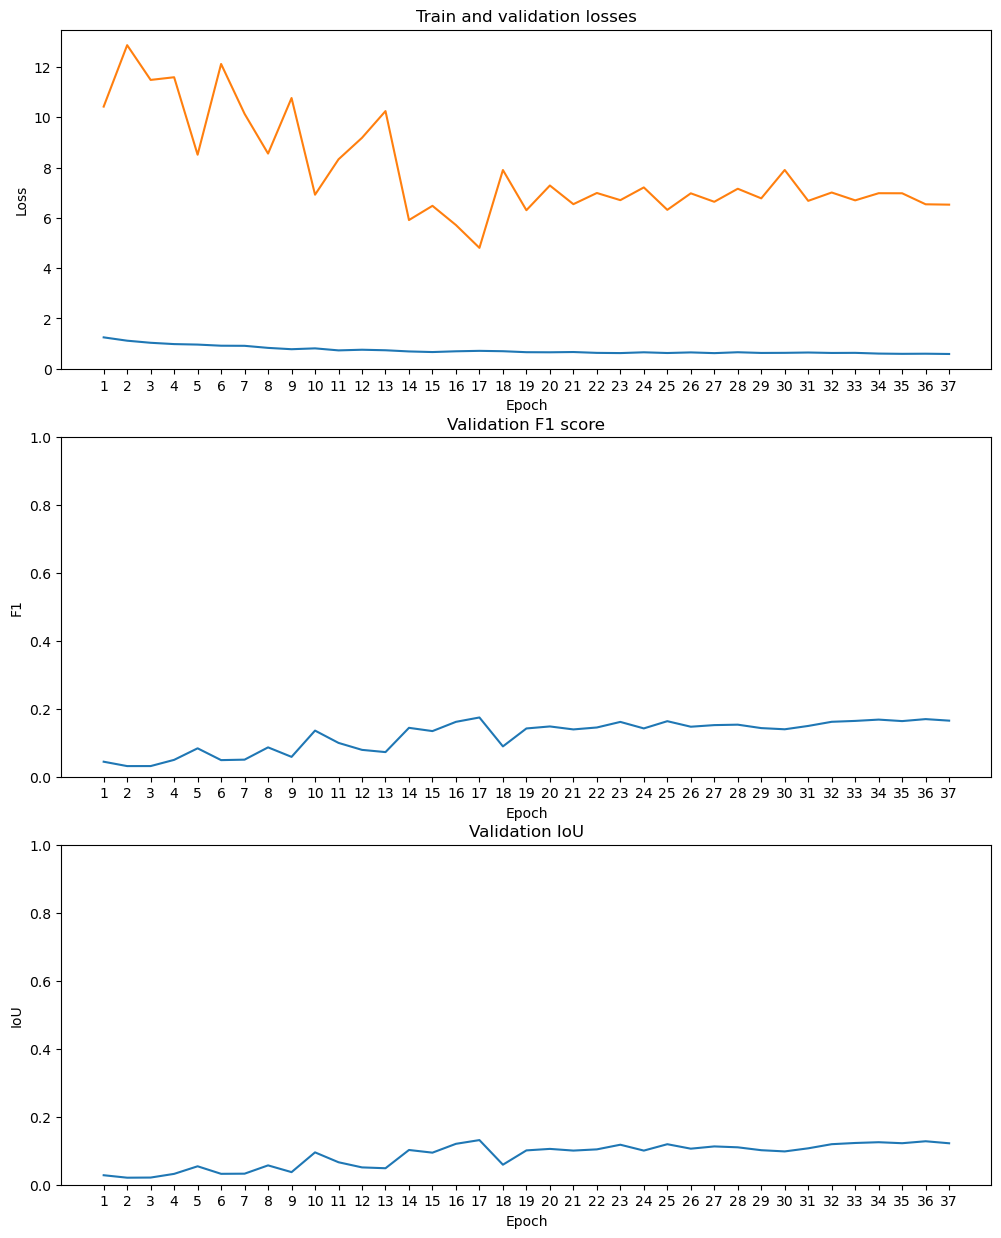

In [ ]:
plot_history(history)

# Building U-Net

## Model

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(mid_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
unet_model = UNet(3, 1).to(device)

In [ ]:
check_point = torch.load("unet_model.pt")
unet_model.load_state_dict(check_point)

In [ ]:
sort_and_display_results(unet_model, test_loader, top_k=5, metric_key='loss')

## Train

In [ ]:
criterion = DiceBCELoss()
metric = IoU()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

In [ ]:
history = train(
    unet_model,
    criterion,
    metric,
    optimizer,
    100,
    batch=16,
    saving_model_path="model/unet_model.pt",
    lr_scheduler=lr_scheduler
)


Fitting nn model


  0%|                                                                                           | 0/100 [00:00<?, ?it/s]


epoch:   1, loss: 1.19788, valid loss: 2.62519, valid F1 score: 0.371, valid IoU: 0.284
Validation loss decreased (inf --> 2.625193). Saving model...


  2%|█▌                                                                               | 2/100 [02:16<1:51:27, 68.24s/it]


epoch:   2, loss: 1.05120, valid loss: 6.23583, valid F1 score: 0.232, valid IoU: 0.157


  3%|██▍                                                                              | 3/100 [03:22<1:48:41, 67.23s/it]


epoch:   3, loss: 1.12295, valid loss: 17.01908, valid F1 score: 0.264, valid IoU: 0.186


  4%|███▏                                                                             | 4/100 [04:27<1:46:10, 66.35s/it]


epoch:   4, loss: 1.02795, valid loss: 8.16177, valid F1 score: 0.329, valid IoU: 0.238


  5%|████                                                                             | 5/100 [05:33<1:44:24, 65.94s/it]


epoch:   5, loss: 1.02318, valid loss: 12.67036, valid F1 score: 0.358, valid IoU: 0.267


  6%|████▊                                                                            | 6/100 [06:39<1:43:31, 66.08s/it]


epoch:   6, loss: 0.98120, valid loss: 3.07523, valid F1 score: 0.357, valid IoU: 0.262


  7%|█████▋                                                                           | 7/100 [07:45<1:42:35, 66.19s/it]


epoch:   7, loss: 0.96008, valid loss: 13.27092, valid F1 score: 0.351, valid IoU: 0.260


  8%|██████▍                                                                          | 8/100 [08:51<1:41:19, 66.09s/it]


epoch:   8, loss: 0.95036, valid loss: 2.86819, valid F1 score: 0.386, valid IoU: 0.294


  9%|███████▎                                                                         | 9/100 [09:57<1:40:02, 65.97s/it]


epoch:   9, loss: 0.92257, valid loss: 4.87739, valid F1 score: 0.372, valid IoU: 0.276


 10%|████████                                                                        | 10/100 [11:02<1:38:34, 65.72s/it]


epoch:  10, loss: 0.97258, valid loss: 7.25972, valid F1 score: 0.267, valid IoU: 0.188


 11%|████████▊                                                                       | 11/100 [12:07<1:37:17, 65.60s/it]


epoch:  11, loss: 0.89066, valid loss: 13.25819, valid F1 score: 0.358, valid IoU: 0.265


 12%|█████████▌                                                                      | 12/100 [13:12<1:35:52, 65.37s/it]


epoch:  12, loss: 0.83165, valid loss: 6.08931, valid F1 score: 0.343, valid IoU: 0.250


 13%|██████████▍                                                                     | 13/100 [14:17<1:34:31, 65.19s/it]


epoch:  13, loss: 0.86784, valid loss: 7.73923, valid F1 score: 0.342, valid IoU: 0.248


 14%|███████████▏                                                                    | 14/100 [15:22<1:33:08, 64.99s/it]


epoch:  14, loss: 0.88800, valid loss: 5.00440, valid F1 score: 0.411, valid IoU: 0.310


 15%|████████████                                                                    | 15/100 [16:26<1:31:54, 64.88s/it]


epoch:  15, loss: 0.80144, valid loss: 3.75496, valid F1 score: 0.394, valid IoU: 0.295


 16%|████████████▊                                                                   | 16/100 [17:31<1:30:37, 64.73s/it]


epoch:  16, loss: 0.78083, valid loss: 3.04770, valid F1 score: 0.411, valid IoU: 0.308


 17%|█████████████▌                                                                  | 17/100 [18:35<1:29:33, 64.74s/it]


epoch:  17, loss: 0.81062, valid loss: 3.08137, valid F1 score: 0.397, valid IoU: 0.297

epoch:  18, loss: 0.90717, valid loss: 1.86303, valid F1 score: 0.423, valid IoU: 0.322
Validation loss decreased (2.625193 --> 1.863028). Saving model...


 19%|███████████████▏                                                                | 19/100 [20:45<1:27:31, 64.84s/it]


epoch:  19, loss: 0.87272, valid loss: 2.71680, valid F1 score: 0.417, valid IoU: 0.316


 20%|████████████████                                                                | 20/100 [21:51<1:26:47, 65.09s/it]


epoch:  20, loss: 0.85483, valid loss: 1.77999, valid F1 score: 0.420, valid IoU: 0.320
Validation loss decreased (1.863028 --> 1.779990). Saving model...


 21%|████████████████▊                                                               | 21/100 [22:56<1:25:42, 65.09s/it]


epoch:  21, loss: 0.77111, valid loss: 1.95790, valid F1 score: 0.413, valid IoU: 0.313


 22%|█████████████████▌                                                              | 22/100 [24:01<1:24:31, 65.02s/it]


epoch:  22, loss: 0.73827, valid loss: 2.16079, valid F1 score: 0.425, valid IoU: 0.335


 23%|██████████████████▍                                                             | 23/100 [25:06<1:23:21, 64.96s/it]


epoch:  23, loss: 0.74308, valid loss: 2.26456, valid F1 score: 0.439, valid IoU: 0.339


 24%|███████████████████▏                                                            | 24/100 [26:10<1:22:10, 64.87s/it]


epoch:  24, loss: 0.71496, valid loss: 2.11482, valid F1 score: 0.446, valid IoU: 0.357


 25%|████████████████████                                                            | 25/100 [27:15<1:21:00, 64.80s/it]


epoch:  25, loss: 0.69933, valid loss: 2.09076, valid F1 score: 0.357, valid IoU: 0.247


 26%|████████████████████▊                                                           | 26/100 [28:19<1:19:50, 64.73s/it]


epoch:  26, loss: 0.75593, valid loss: 1.95096, valid F1 score: 0.401, valid IoU: 0.295


 27%|█████████████████████▌                                                          | 27/100 [29:24<1:18:39, 64.65s/it]


epoch:  27, loss: 0.71633, valid loss: 2.10076, valid F1 score: 0.421, valid IoU: 0.312


 28%|██████████████████████▍                                                         | 28/100 [30:28<1:17:28, 64.57s/it]


epoch:  28, loss: 0.76618, valid loss: 2.62531, valid F1 score: 0.388, valid IoU: 0.285


 29%|███████████████████████▏                                                        | 29/100 [31:33<1:16:22, 64.54s/it]


epoch:  29, loss: 0.67238, valid loss: 2.27017, valid F1 score: 0.429, valid IoU: 0.329


 30%|████████████████████████                                                        | 30/100 [32:37<1:15:09, 64.42s/it]


epoch:  30, loss: 0.71021, valid loss: 2.10405, valid F1 score: 0.421, valid IoU: 0.312


 31%|████████████████████████▊                                                       | 31/100 [33:41<1:14:01, 64.37s/it]


epoch:  31, loss: 0.72078, valid loss: 2.38318, valid F1 score: 0.391, valid IoU: 0.279


 32%|█████████████████████████▌                                                      | 32/100 [34:46<1:13:01, 64.43s/it]


epoch:  32, loss: 0.71503, valid loss: 2.95554, valid F1 score: 0.431, valid IoU: 0.323


 33%|██████████████████████████▍                                                     | 33/100 [35:50<1:11:54, 64.40s/it]


epoch:  33, loss: 0.73626, valid loss: 2.95448, valid F1 score: 0.438, valid IoU: 0.336


 34%|███████████████████████████▏                                                    | 34/100 [36:54<1:10:49, 64.38s/it]


epoch:  34, loss: 0.73175, valid loss: 2.25050, valid F1 score: 0.422, valid IoU: 0.322


 35%|████████████████████████████                                                    | 35/100 [37:59<1:09:45, 64.39s/it]


epoch:  35, loss: 0.68372, valid loss: 2.62877, valid F1 score: 0.437, valid IoU: 0.327


 36%|████████████████████████████▊                                                   | 36/100 [39:03<1:08:40, 64.39s/it]


epoch:  36, loss: 0.66722, valid loss: 2.81684, valid F1 score: 0.444, valid IoU: 0.335


 37%|█████████████████████████████▌                                                  | 37/100 [40:08<1:07:37, 64.41s/it]


epoch:  37, loss: 0.68157, valid loss: 2.93348, valid F1 score: 0.442, valid IoU: 0.340


 38%|██████████████████████████████▍                                                 | 38/100 [41:12<1:06:36, 64.45s/it]


epoch:  38, loss: 0.73730, valid loss: 2.61509, valid F1 score: 0.434, valid IoU: 0.330


 39%|███████████████████████████████▏                                                | 39/100 [42:17<1:05:36, 64.53s/it]


epoch:  39, loss: 0.71091, valid loss: 2.05551, valid F1 score: 0.446, valid IoU: 0.345


 39%|███████████████████████████████▏                                                | 39/100 [43:22<1:07:50, 66.73s/it]


epoch:  40, loss: 0.66166, valid loss: 4.13546, valid F1 score: 0.440, valid IoU: 0.334
Terminated Training for Early Stopping at Epoch 40
Fit time: 2602.3031210899353 s



/tmp/ipykernel_132842/2406692714.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load("model.pt", map_location=device)


Saving model
Test loss: 3.73582, test F1 score: 0.405, test IoU: 0.319


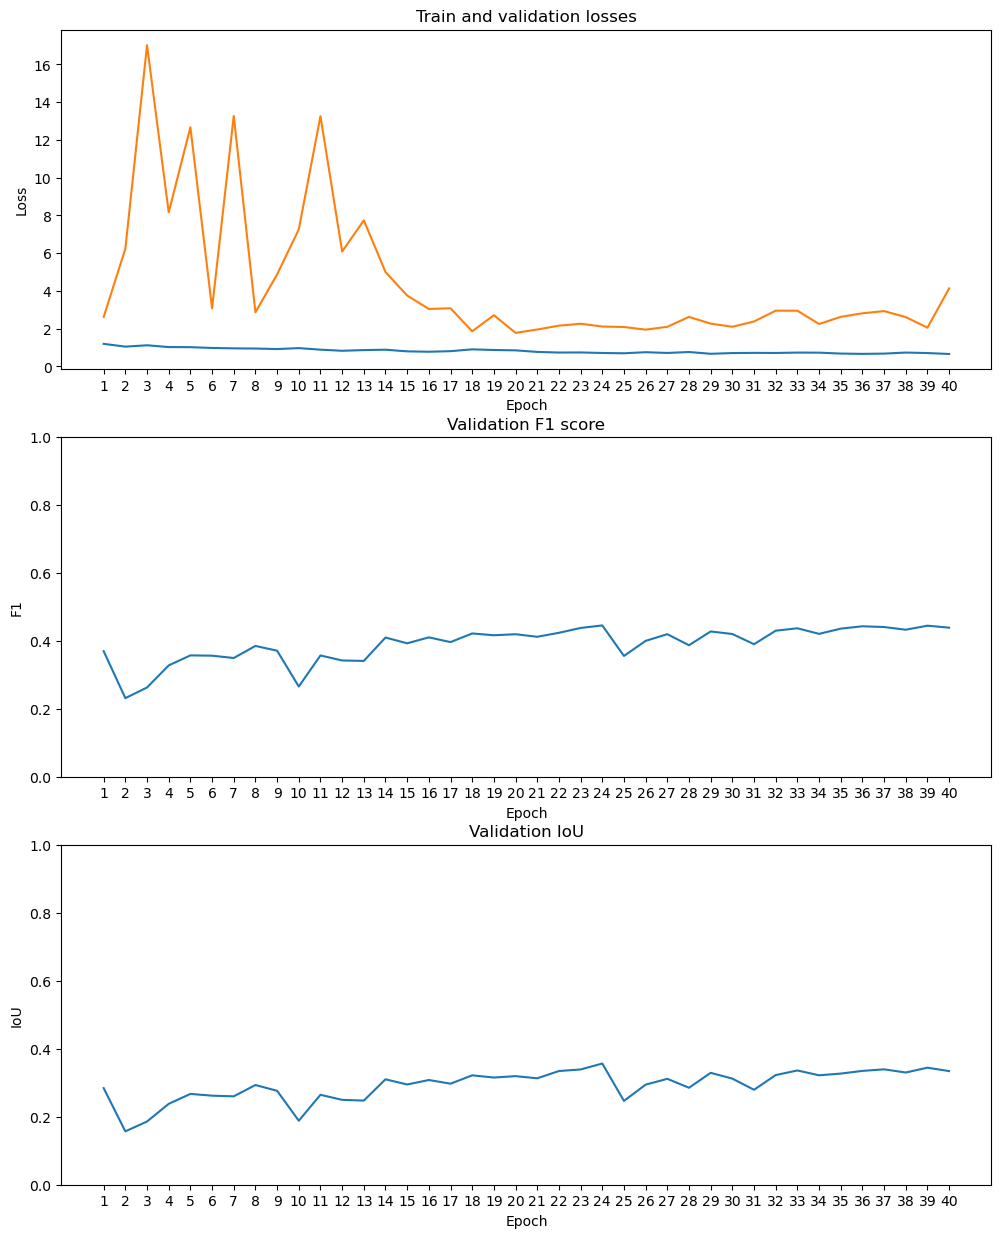

In [ ]:
plot_history(history)